RAW BOARD: 


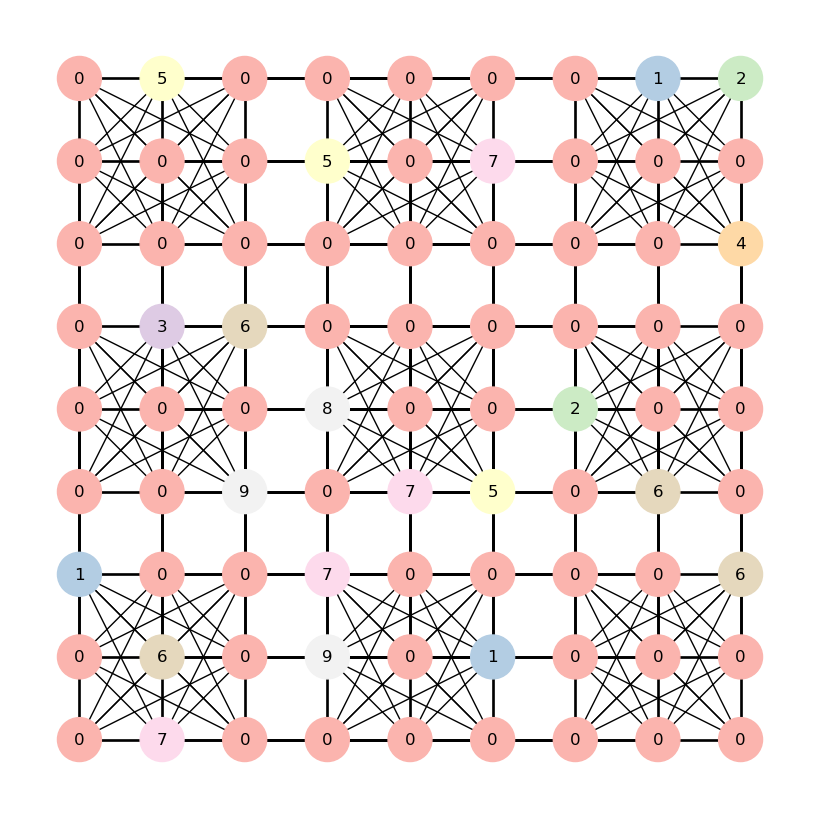




SOLVED BOARD: 


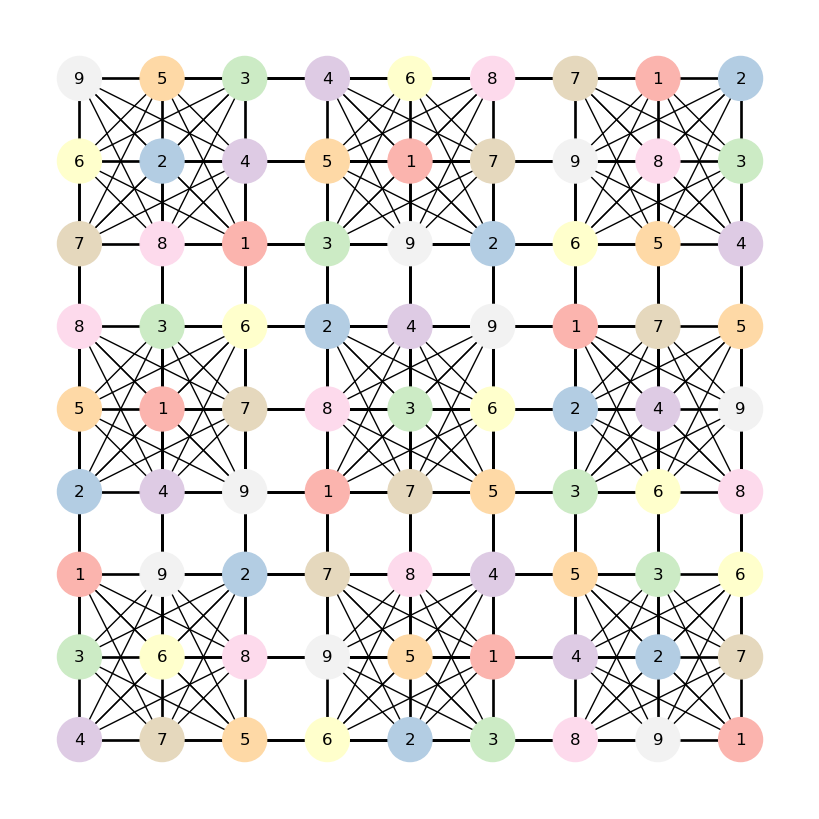

In [4]:
from time import sleep as pausefor
from copy import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
 
def generate_board():
  #retirado de https://stackoverflow.com/questions/45471152/how-to-create-a-sudoku-puzzle-in-python
  # got from ...
  base  = 3
  side  = base*base
 
  # pattern for a baseline valid solution
  def pattern(r,c): return (base*(r%base)+r//base+c)%side
 
  # randomize rows, columns and numbers (of valid base pattern)
  from random import sample  
  def shuffle(s): return sample(s,len(s)) 
  rBase = range(base) 
  rows  = [ g*base + r for g in shuffle(rBase) for r in shuffle(rBase) ] 
  cols  = [ g*base + c for g in shuffle(rBase) for c in shuffle(rBase) ]
  nums  = shuffle(range(1,base*base+1))
 
  # produce board using randomized baseline pattern
  board = [ [nums[pattern(r,c)] for c in cols] for r in rows ]
 
  squares = side*side
  empties = squares * 3//4
  for p in sample(range(squares),empties):
    board[p//side][p%side] = 0
  return board

def gen_sudoku_and_graph():
  sudoku_board = generate_board()
  G = make_graph_from_board(sudoku_board)
  # print(G) # uncomment to see the graph
  B = {v: sudoku_board[v[0]][v[1]] for v in G} #colors of vertices

  return G,B

def get_adjacents_from_board(board, lin, col):
    adj = [(lin, j) for j in range(len(board[lin])) if j != col]
    adj.extend([(i, col) for i in range(len(board)) if i != lin])
 
    lin_start = (lin//3)*3
    col_start = (col//3)*3
    for i in range(3):
      for j in range(3):
        if (i+lin_start, j+col_start) not in adj and i != lin and j != col:
          adj.append((i+lin_start, j+col_start))
    
    return adj
 
 
def make_graph_from_board(board):
  G = {}
 
  for x in range(len(board)):
    for y in range(len(board[x])):
        G[(x,y)] = get_adjacents_from_board(board, x, y)
  return G
 
def get_colored_adjacents_number(G, B):
  L = []
  for v in G:
    n = 0
    if B[v] == 0:
      for u in G[v]:
        if(B[u] != 0):
          n += 1
      L.append((n, v))
  return L
 
def is_ok(G, B, v, c):
  for u in G[v]: # para cada adjacente u de v
    if B[u] == c: # se cor de u for igual a cor que quero colorir
      #print("Cor incorreta! Vertice:", u, " e cor:", c)
      #pausefor(0.4)
      return False
  return True

def count_number_of_possibilities(G, B, v):
  allc = set()
  for u in G[v]:
    allc.add(B[u])
  
  return 9-len(allc)

def get_vertex_with_least_number_of_possibilities(G, B):
  bv = None
  for u in G:
    if bv != None:
      np = count_number_of_possibilities(G, B, u)
      if np < bv[0] and B[u] == 0:
        bv = (np, u)
    else:
      if B[u] == 0:
        bv = (count_number_of_possibilities(G, B, u), u)
  
  return bv[1] if bv else None


def RESOLUCAO2(G, L, C, B, llength): # works, buts slooow
  # uncomment to visualize the algorithm working
  i = 0
  while i != llength:
    v = L[i][1]
    c = B[v]
    while c < 9: # all colors from currentColor to 9 (maximum color)
      #print('current vertex of index:',i,', current color:', B[v], ', trying color: ', c+1); pausefor(0.5)
      if is_ok(G, B, v, c+1):
        #print('current vertex of index:',i,'found color:', c+1); pausefor(0.5)
        B[v] = c + 1
        i += 1
        break
      else:
        c += 1
    else:
      #print('couldn\'t find color for vertex:',i,', backtracking to index:',i-1); pausefor(0.5)
      B[v] = 0
      i -= 1
 
def RESOLUCAO(G, B, C, remaining):
  # uncomment to visualize the algorithm working!!
  v = get_vertex_with_least_number_of_possibilities(G, B)
  if v == None:
    return True
  
  for c in C:
    #print("Current vertex:", v, " and there are",remaining,"remaining", ", trying color:", c ); pausefor(0.5)
    if is_ok(G, B, v, c):
      # print("Current vertex:", v, " and there are",remaining,"remaining", ", got color:", c ); pausefor(0.5)
      B[v] = c
      if remaining > 1:
        if (RESOLUCAO(G, B, C, remaining-1)):
          return True
    
    if c == 9: # last color and not possible
      #print("what? going back... to remaining " + str(remaining+1)); pausefor(0.5)
      B[v] = 0
      return False


def print_sudoku(B): # where is is the sudoku board
  puzzle = [[B[(i, j)] for j in range(9)] for i in range(9)]
  my=np.asarray(puzzle)
  print_su(my)
  

def solve(G, B, algorithm):
    L = sorted(get_colored_adjacents_number(G, B), key=lambda x: x[0], reverse=True) #only used at RESOLUCAO2
    run = [
        lambda: RESOLUCAO(G, B, [1,2,3,4,5,6,7,8,9], len(B.keys())),
        lambda: RESOLUCAO2(G, L, [1,2,3,4,5,6,7,8,9], B, len(L)),
    ]

    run[algorithm-1]()

def print_su(puzzle):
    n = 3
    G = nx.sudoku_graph(n)
    mapping = dict(zip(G.nodes(), puzzle.flatten()))
    pos = dict(zip(list(G.nodes()), nx.grid_2d_graph(n * n, n * n)))
    low, *_, high = sorted(mapping.values())
    norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Pastel1)
    plt.figure(figsize=(8,8))
    nx.draw(
        G,
        labels=mapping,
        pos=pos,
        with_labels=True,
        node_color=[mapper.to_rgba(i) for i in mapping.values()],
        width=1,
        node_size=1000,
    )
    plt.show()


G, B = gen_sudoku_and_graph()
new=np.asarray(B)


print("RAW BOARD: ")
print_sudoku(B)
print("\n\n")

    # END: CREATION OF GRAPH

    # BEGIN: RESOLUTION

    # Third argument values [1,2]
    # 1: uses RESOLUCAO
    # 2: uses RESOLUCAO2
solve(G, B, 1)


print("SOLVED BOARD: ")
print_sudoku(B)

    # END: RESOLUTION